In [1]:
#import
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [2]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

df.head(10)

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343
11,0,0.006,9.212541
12,0,0.143,10.143191
13,0,3.513,10.274632
14,0,1.672,7.852028
15,1,1.780,6.432380


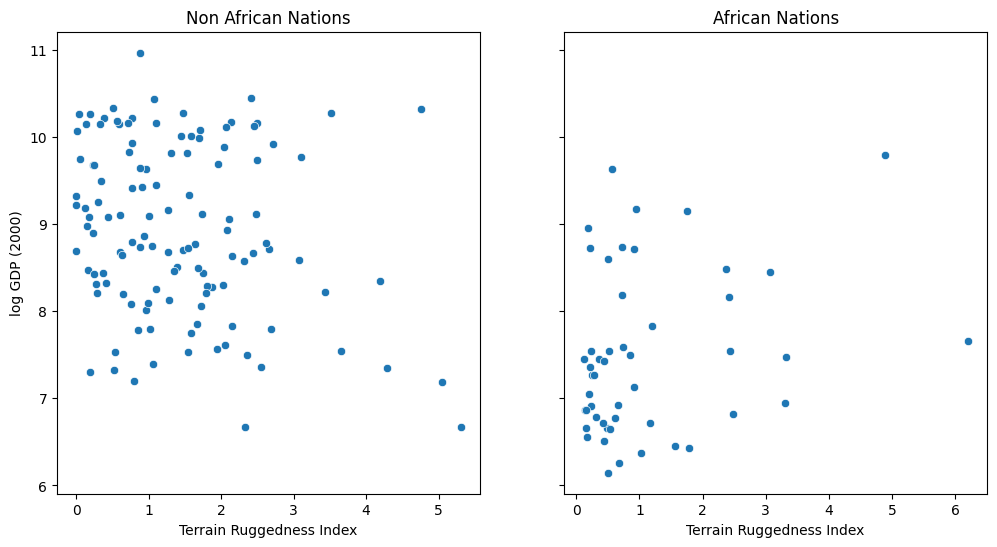

In [3]:
# subplot with 2 columns representing terrain ruggedness in african and non african nations

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [4]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [5]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

In [7]:
# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3179.7847
[iteration 0100] loss: 1616.1371
[iteration 0150] loss: 1109.4115
[iteration 0200] loss: 833.7544
[iteration 0250] loss: 637.5822
[iteration 0300] loss: 488.2652
[iteration 0350] loss: 376.4650
[iteration 0400] loss: 296.0483
[iteration 0450] loss: 240.6140
[iteration 0500] loss: 203.9385
[iteration 0550] loss: 180.6171
[iteration 0600] loss: 166.3493
[iteration 0650] loss: 157.9457
[iteration 0700] loss: 153.1786
[iteration 0750] loss: 150.5735
[iteration 0800] loss: 149.2020
[iteration 0850] loss: 148.5065
[iteration 0900] loss: 148.1668
[iteration 0950] loss: 148.0070
[iteration 1000] loss: 147.9347
[iteration 1050] loss: 147.9032
[iteration 1100] loss: 147.8900
[iteration 1150] loss: 147.8847
[iteration 1200] loss: 147.8827
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8816
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94785

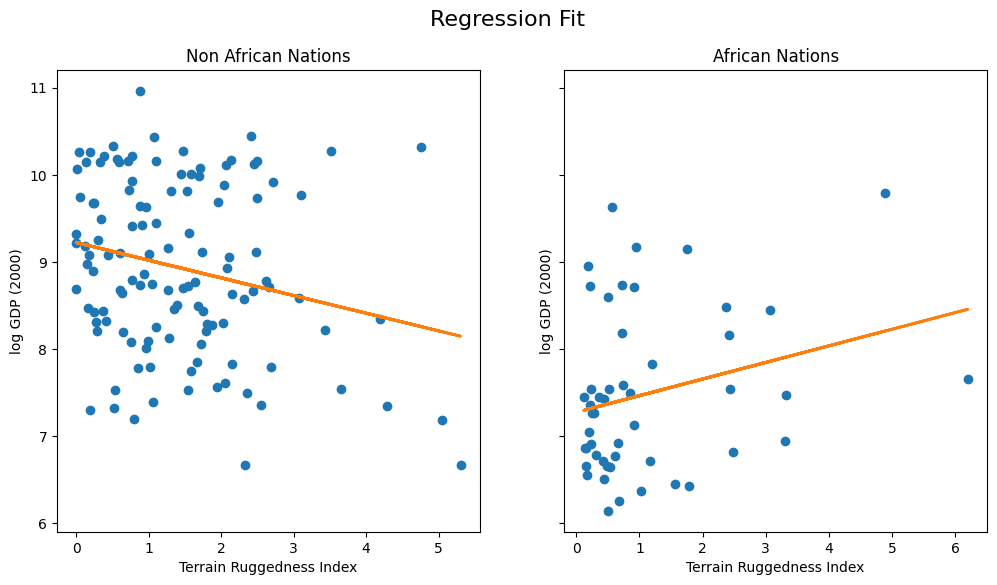

In [18]:
# again two subplots for african and non african nations

fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## Bayesian
In order to make our linear regression Bayesian, we need to put priors on the parameters $w$ and $b$. These are distributions that represent our prior belief about reasonable values for $w$ and $b$ (before observing any data).

In [19]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [20]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [21]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [ ]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

In [23]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2193, -1.7980, -0.1751,  0.3855,  9.2135])
AutoDiagonalNormal.scale tensor([0.0596, 0.1275, 0.0424, 0.0703, 0.0692])


In [35]:
#guide.quantiles([0.25, 0.50, 0.75])
guide.quantiles([0.5])

{'sigma': tensor([0.9803]),
 'linear.weight': tensor([[[-1.7980, -0.1751,  0.3855]]]),
 'linear.bias': tensor([[9.2135]])}

In [36]:
# in order to evaluate our model we’ll generate some predictive samples and look at the posteriors
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [39]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

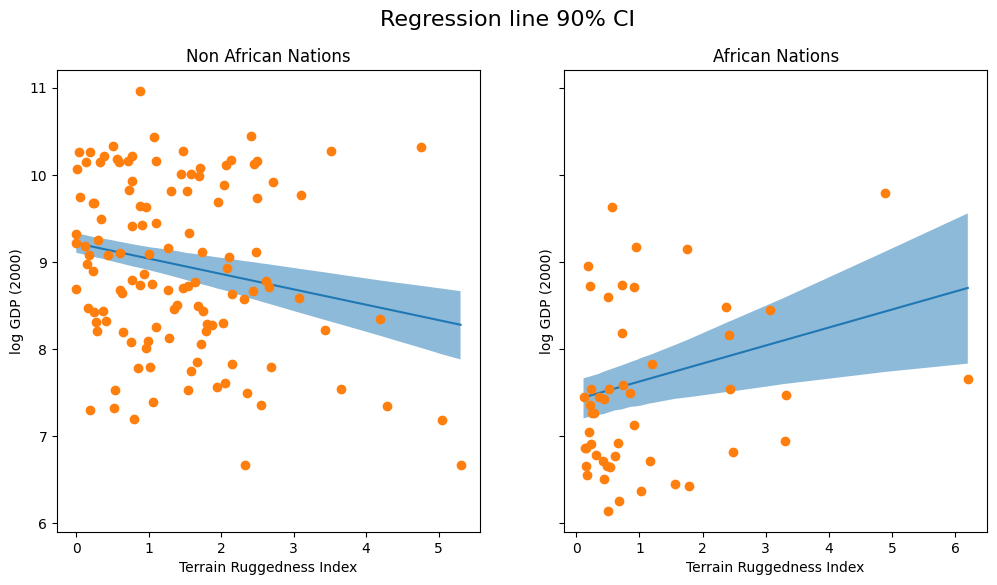

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

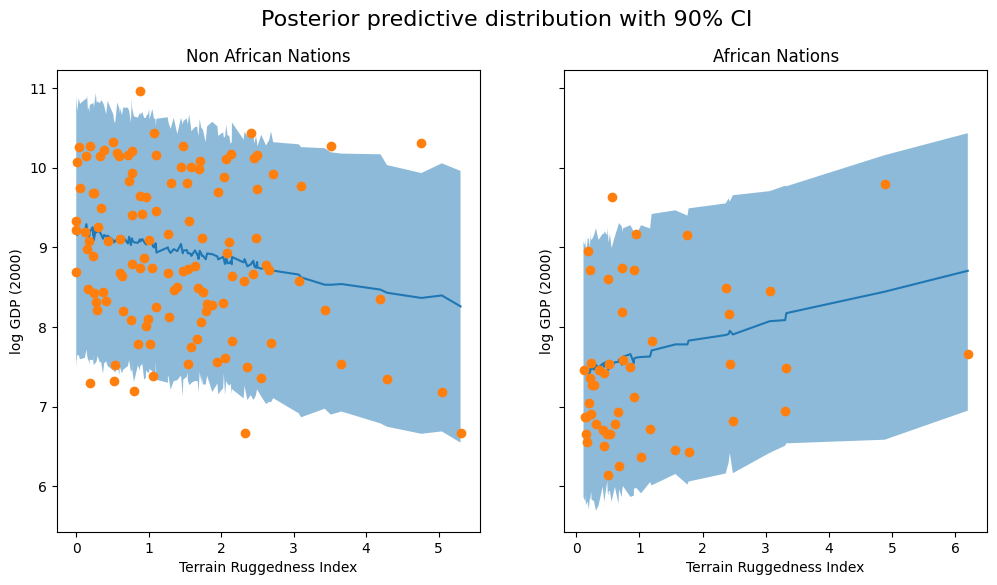

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

### Same example with different strategy

In [1]:
import logging
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.8.4')

In [2]:
%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

In [3]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    # initialize the W parameters
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [6]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)
train

tensor([[1.0000e+00, 8.5800e-01, 7.4926e+00],
        [0.0000e+00, 3.4270e+00, 8.2169e+00],
        [0.0000e+00, 7.6900e-01, 9.9333e+00],
        [0.0000e+00, 7.7500e-01, 9.4070e+00],
        [0.0000e+00, 2.6880e+00, 7.7923e+00],
        [0.0000e+00, 6.0000e-03, 9.2125e+00],
        [0.0000e+00, 1.4300e-01, 1.0143e+01],
        [0.0000e+00, 3.5130e+00, 1.0275e+01],
        [0.0000e+00, 1.6720e+00, 7.8520e+00],
        [1.0000e+00, 1.7800e+00, 6.4324e+00],
        [0.0000e+00, 3.8800e-01, 1.0215e+01],
        [1.0000e+00, 1.4100e-01, 6.8661e+00],
        [1.0000e+00, 2.3600e-01, 6.9062e+00],
        [0.0000e+00, 1.8600e-01, 7.2992e+00],
        [0.0000e+00, 1.4790e+00, 8.6960e+00],
        [0.0000e+00, 2.3100e-01, 9.6758e+00],
        [0.0000e+00, 5.5000e-02, 9.7396e+00],
        [0.0000e+00, 2.3110e+00, 8.5745e+00],
        [0.0000e+00, 1.6400e-01, 8.4768e+00],
        [0.0000e+00, 6.0700e-01, 8.6775e+00],
        [0.0000e+00, 8.5300e-01, 7.7827e+00],
        [0.0000e+00, 2.4000e-01, 8

In [7]:
from pyro.infer import SVI, Trace_ELBO

svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
num_iters = 5000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 5795.468078792095
Elbo loss: 415.8169754743576
Elbo loss: 250.71914893388748
Elbo loss: 247.19455778598785
Elbo loss: 249.20037311315536
Elbo loss: 250.9648750424385
Elbo loss: 249.35092467069626
Elbo loss: 248.78314006328583
Elbo loss: 248.6214217543602
Elbo loss: 250.42745810747147


In [8]:
from pyro.infer import Predictive


num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)

In [9]:
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}

In [13]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%      50%       75%       95%
0  9.177024  0.059607  9.078109  9.140462  9.17821  9.217097  9.271518 

Site: bA
       mean       std       5%       25%       50%       75%       95%
0 -1.890622  0.122805 -2.08849 -1.979106 -1.887476 -1.803683 -1.700853 

Site: bR
       mean       std       5%       25%       50%       75%       95%
0 -0.157847  0.039538 -0.22324 -0.183672 -0.157872 -0.133102 -0.091713 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.304515  0.067683  0.194583  0.259464  0.304908  0.348932  0.415128 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.902898  0.047971  0.824166  0.870317  0.901982  0.935171  0.981577 



## Trying to adapt this model to our problem